In [1]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import set_config
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import logging

In [2]:
#sklearn will return a pandas dataframe insted of a numpy array
set_config(transform_output="pandas")
random_state = 42
sns.set_style("darkgrid")


# Load Data

In [3]:
nba       = pd.read_csv('../data/nba/nba_salaries.csv')
insurance = pd.read_csv('../data/insurance/insurance.csv')
airline   = pd.read_csv('../data/airline/train.csv')
airbnb    = pd.read_csv('../data/airbnb/listings.csv')

# Visualizing Distributions

In [4]:
def visualize_effects_outliers_treatment(df_original: pd.DataFrame, 
                                        df_cleaned: pd.DataFrame,
                                        feature: str, 
                                        outlier_treatment: str):
    """
    Visualize the effect of the outlier treatment on a feature.


    Parameters
    ----------
    df_original : pd.DataFrame
        The original dataframe.
    df_cleaned : pd.DataFrame
        The cleaned dataframe.
    feature : str
        The feature to be visualized.
    outlier_treatment : str
        The treatment that was applied to the outliers.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(x=feature, data=df_original, ax=ax[0], kde = True)
    sns.histplot(x=feature, data=df_cleaned, ax=ax[1], kde = True )
    ax[0].set_title(f'Raw {feature}')
    title = f'Cleaned {feature}\n'
    title += f'Outlier treatment: {outlier_treatment}'
    ax[1].set_title(title)
    plt.show()

# Managing outliers one feature at a time

In [6]:
def calculate_outlier_threshold(df: pd.DataFrame, feature: str, 
                               skew_thresold: float = 1) -> tuple[float, float]: 
    """
    Calculate the inferior and superior thresholds for outlier detection.
    Values above max_thresh and values below min_thresh are considered outliers

    Args:
        df (pd.DataFrame): The dataframe containing the feature.
        feature (str): The name of the feature to be processed.
        skew_thresold (float): The skewness threshold used to determine whether the distribution is normal or not.

    Returns:    
        tuple: A tuple containing the inferior and superior thresholds for outlier detection.
    """
    skew = df[feature].skew()
    if skew > -1 * skew_thresold and skew < skew_thresold:
        #empirical rule to detect outliers in normal distributions
        print('normal')
        min_thresh = df[feature].mean() - 3 * df[feature].std()
        max_thresh = df[feature].mean() + 3 * df[feature].std()
    else: 
        #apply the Tukey rule to detect outliers in distributions that are not normal
        print('tukey')
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1 #interquartile range
        max_thresh = q3 + 1.5 * (iqr) 
        min_thresh = q1 - 1.5 * (iqr)
    
    return (min_thresh, max_thresh)    

def clean_outliers(df: pd.DataFrame, features_list: list = None, 
                   outlier_treatment: str = None, output_column: str = None, 
                   skew_thresold: float = 1) -> pd.DataFrame:
    '''
    Detect and treat outliers. Two criteria will be used to detect outliers:
        - empirical rule to detect outliers in normal distributions;
        - Tukey rule to detect outliers in distributions that are not normal.
    A distribution will be considered normal when its skewness is between -1 * skew_thresold and skew_thresold.
    One of the two criteria will be used to calculate max_thresh and min_thresh. Values above max_thresh and 
    values below min_thresh are considered outliers.
    

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to be cleaned.
    features_list : list, optional
        The list of features to be cleaned, by default, is None. If None, the function will clean all features.
    outlier_treatment : str, optional
        The treatment to be applied to outliers, by default, None. Can be 'remove'; 'replace'; 'impute', or None:
            - remove: rows containing outliers are completely removed;
            - replace: outliers above max_thresh and outliers below min_thresh are replaced by max_thresh and min_thresh, respectively;
            - impute: outliers above max_thresh and outliers below min_thresh are imputed using the Iterative imputer method form scikit-learn;
            - None: no treatment is applied to outliers.
    output_column : str, optional
        The name of the output column, by default is None. The output column will not be used when calculating the values to be imputed. 
        If None, it is considered that the output column is not in df.
    skew_thresold : float, optional
        The skewness threshold for a distribution to be considered normal, by default 1.

    Returns
    -------
    pd.DataFrame
        The cleaned dataframe.
    
    '''

    df = df.copy()
    df = df.dropna()
    
    if features_list is None:
        features_list = df.columns.to_list()

    if outlier_treatment not in ['remove', 'replace', 'impute', None]:
        print(f'The outlier_treatment {outlier_treatment} is not valid. No treatment will be applied to outliers.')
        outlier_treatment = None

    #remove output_column from features_list. The output column can not be used when calculating the values to be imputed
    if output_column is not None and output_column in features_list:
        features_list_impute_method = features_list.copy()
        features_list_impute_method.remove(output_column)
    else:
        features_list_impute_method = features_list
 

    for feature in features_list:
        
        if feature == output_column and outlier_treatment == 'impute':
            continue
                
        #test whether the feature is in the dataframe
        if feature in df.columns:
            #only numeric columns will be cleaned
            if pd.api.types.is_numeric_dtype(df[feature]):

                #test whether the feature has only one unique value
                if df[feature].nunique() == 1:
                    print(f'The feature {feature} has only one unique value and was therefore ignored.')

                #test whether the feature is binary (only true or false values)
                elif (set(df[feature].dropna().unique()).issubset({0, 1}) or
                        set(df[feature].dropna().unique()).issubset({True, False})):
                    print(f'The feature {feature} is binary (only true or false values) and was therefore ignored.')

                # look for outliers
                else:
                    #calculate max_thresh and min_thresh
                    
                    min_thresh, max_thresh = calculate_outlier_threshold(df, feature, skew_thresold)
                    

                    #values above max_thresh and values below min_thresh are considered outliers
                    count_max_outlier = len(df.loc[df[feature] > max_thresh])
                    count_min_outlier = len(df.loc[df[feature] < min_thresh])
                    print(f'The feature {feature} has {count_max_outlier} values above {max_thresh}')
                    print(f'The feature {feature} has {count_min_outlier} values below {min_thresh}')

                    has_outliers = count_max_outlier > 0 or count_min_outlier > 0

                    if not has_outliers:                  
                        continue

                    if outlier_treatment == 'remove':
                        df = df[(df[feature] >= min_thresh) & (df[feature] <= max_thresh)]
                        print(f'{feature}: outliers removed')

                    elif outlier_treatment == 'replace':
                        if not pd.api.types.is_float_dtype(df[feature]):
                            df[feature] = df[feature].astype(float) #convert to float
                        print(f'{feature}: outliers replaced')
                        df.loc[df[feature] > max_thresh, feature] = max_thresh
                        df.loc[df[feature] < min_thresh, feature] = min_thresh

                    elif outlier_treatment == 'impute':
                        df_temp = df[features_list_impute_method].copy()
                        df_temp.loc[df_temp[feature] > max_thresh, feature] = np.nan
                        df_temp.loc[df_temp[feature] < min_thresh, feature] = np.nan

                        df_temp = pd.get_dummies(df_temp, drop_first = True)
                        imputer = IterativeImputer(max_iter=10, random_state = random_state)
                        df_temp = imputer.fit_transform(df_temp)
                        df[feature] = df_temp[feature]

            else:
                print(f'The feature {feature} is not numeric and was therefore ignored')

        else:
            print(f'A {feature} não foi encontrada no dataframe e foi ignorada')

    return df




## Examples

The following three cells are examples of how to use the function.
The difference between the three cells is the value of the argument `outlier_treatment`.

1. remove;
2. replace;
3. impute.

normal
The feature age has 0 values above 81.35690654870976
The feature age has 0 values below -2.942855726587176
The feature sex is not numeric and was therefore ignored
normal
The feature bmi has 4 values above 48.95795759602359
The feature bmi has 0 values below 12.368836125949507
bmi: outliers removed
normal
The feature children has 18 values above 4.716345622635256
The feature children has 0 values below -2.522942324284431
children: outliers removed
The feature smoker is not numeric and was therefore ignored
The feature region is not numeric and was therefore ignored
tukey
The feature charges has 129 values above 35232.529987500006
The feature charges has 0 values below -13588.807712500002
charges: outliers removed


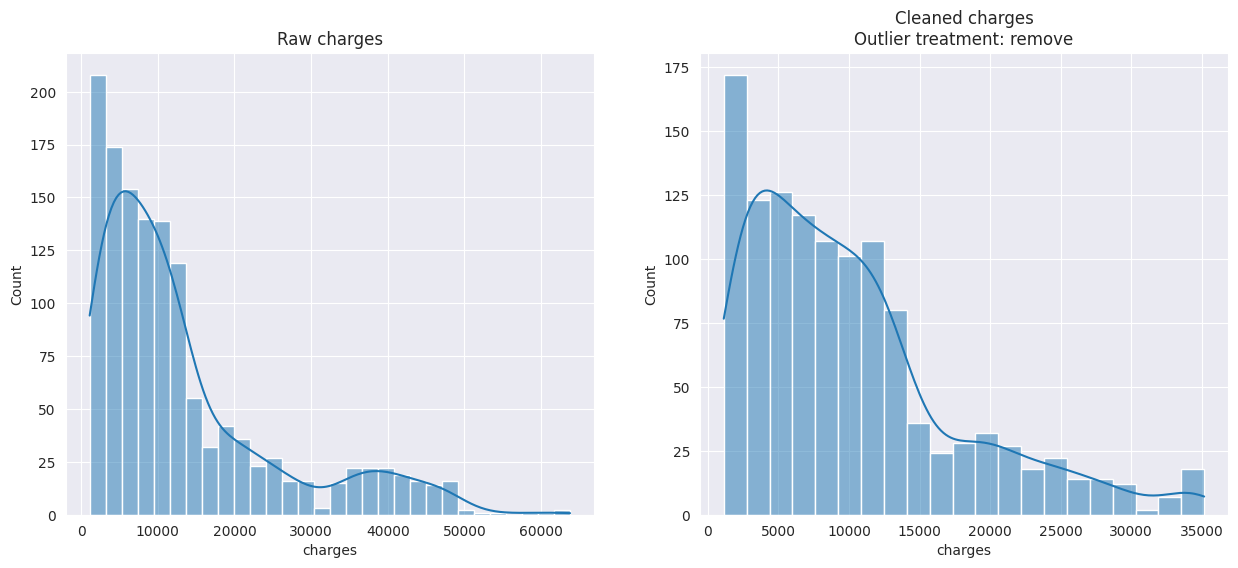

In [8]:
insurance_cleaned = clean_outliers(insurance, 
                                   outlier_treatment = 'remove',
                                   output_column = 'charges')

visualize_effects_outliers_treatment(insurance,
                                     insurance_cleaned,
                                     'charges',
                                     'remove')

normal
The feature age has 0 values above 81.35690654870976
The feature age has 0 values below -2.942855726587176
The feature sex is not numeric and was therefore ignored
normal
The feature bmi has 4 values above 48.95795759602359
The feature bmi has 0 values below 12.368836125949507
bmi: outliers replaced
normal
The feature children has 18 values above 4.711396007088641
The feature children has 0 values below -2.521560431602842
children: outliers replaced
The feature smoker is not numeric and was therefore ignored
The feature region is not numeric and was therefore ignored
tukey
The feature charges has 139 values above 34489.350562499996
The feature charges has 0 values below -13109.1508975
charges: outliers replaced


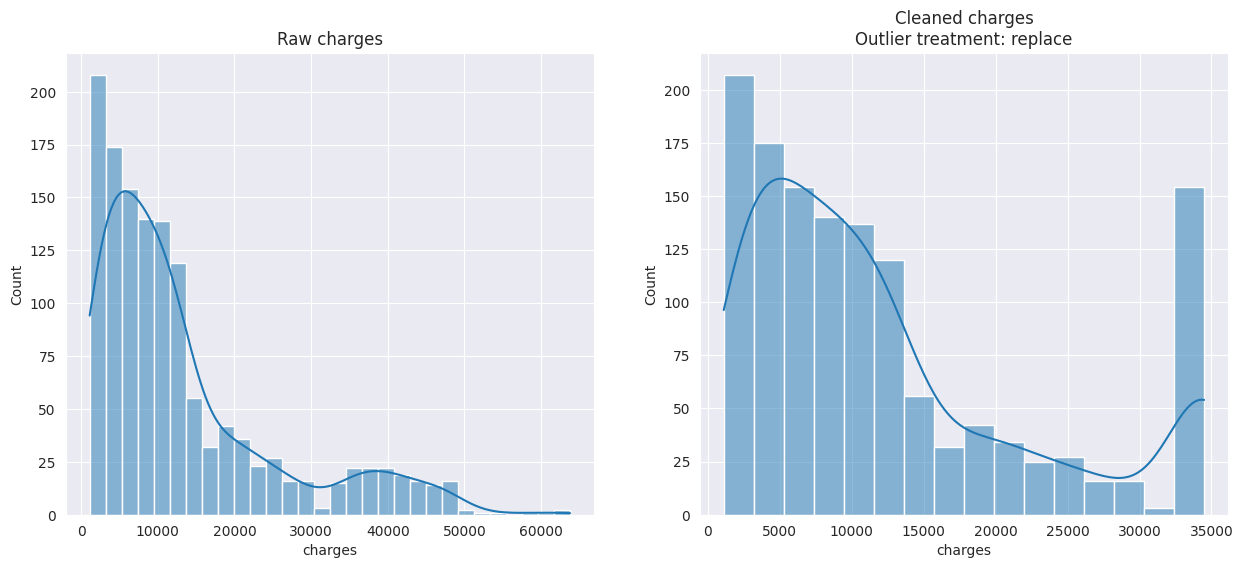

In [9]:
insurance_cleaned = clean_outliers(insurance, 
                                   outlier_treatment = 'replace',
                                   output_column = 'charges')

visualize_effects_outliers_treatment(insurance,
                                     insurance_cleaned,
                                     'charges',
                                     'replace')

normal
The feature age has 0 values above 81.35690654870976
The feature age has 0 values below -2.942855726587176
The feature sex is not numeric and was therefore ignored
normal
The feature bmi has 4 values above 48.95795759602359
The feature bmi has 0 values below 12.368836125949507
normal
The feature children has 18 values above 4.711396007088641
The feature children has 0 values below -2.521560431602842
The feature smoker is not numeric and was therefore ignored
The feature region is not numeric and was therefore ignored


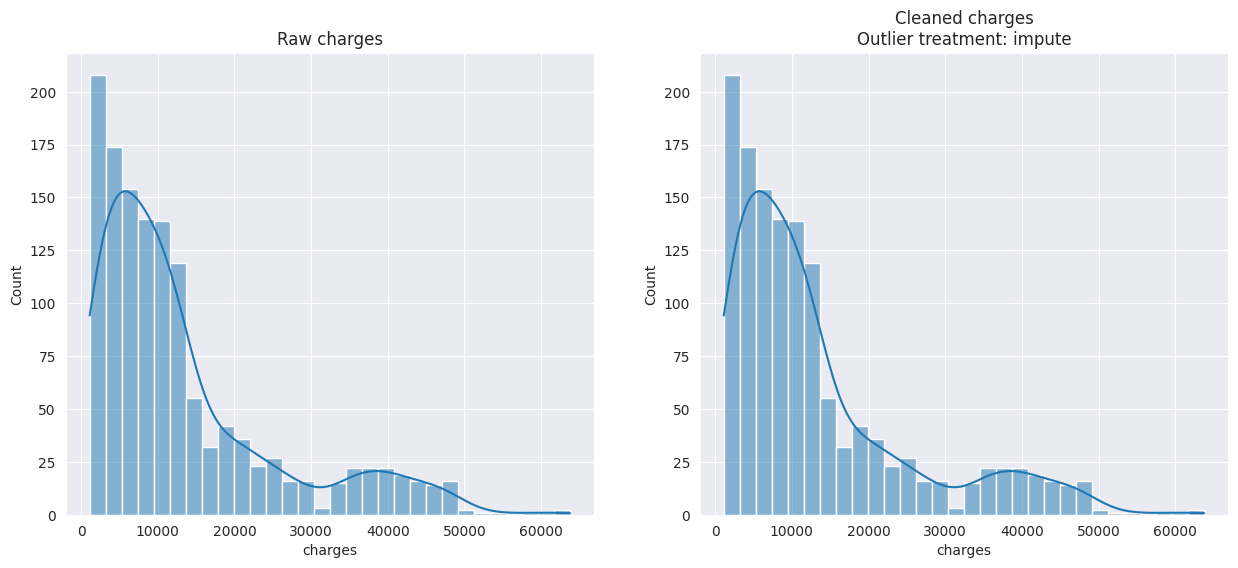

In [10]:
insurance_cleaned = clean_outliers(insurance, 
                                   outlier_treatment = 'impute',
                                   output_column = 'charges')

visualize_effects_outliers_treatment(insurance,
                                     insurance_cleaned,
                                     'charges',
                                     'impute')

# Managing Outliers all features at once using DBSCAN

Two functions:

1. search_eps_dbscan: search the best value of the eps parameter;
2. clean_outliers_dbscan: clean outliers using DBSCAN.

## search_eps_dbscan

In [14]:
def search_eps_dbscan(df: pd.DataFrame, 
                      distance_metric: str = 'manhattan', 
                      min_samples: int = 5, 
                      eps_step: float = 0.01, 
                      desired_percentage_outliers: float = 0.02,
                      max_eps: float = 5.0,
                      plot: bool = True,
                      verbose: bool = True
                     ) -> tuple[pd.DataFrame, float]:
    """
    Find the optimal eps value for DBSCAN that results in a desired percentage of outliers.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - distance_metric (str): Distance metric for DBSCAN.
    - min_samples (int): Minimum samples for core point in DBSCAN.
    - eps_step (float): Step size for increasing eps.
    - desired_percentage_outliers (float): Target outlier percentage (0-1).
    - max_eps (float): Upper limit for eps search.
    - plot (bool): Whether to plot eps vs. outlier percentage.
    - verbose (bool): Whether to log cleaning info.

    Returns:
    - tuple[pd.DataFrame, float]: DataFrame of eps vs. outlier percentages, and selected eps value.
    """
    if df.empty:
        raise ValueError("Input DataFrame is empty.")

    df_temp = df.dropna(how='all', axis=1).dropna(how='any', axis=0)

    if verbose:
        removed_rows = df.shape[0] - df_temp.shape[0]
        removed_cols = df.shape[1] - df_temp.shape[1]
        logging.info(f"{removed_rows} rows and {removed_cols} columns removed due to missing values.")

    # Encode categorical variables
    df_temp = pd.get_dummies(df_temp, drop_first=True)

    if df_temp.empty:
        raise ValueError("DataFrame became empty after encoding.")

    # Scale features
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_temp)

    # Store eps and outlier percentages
    eps_values = []
    outlier_percentages = []

    for eps in np.arange(eps_step, max_eps + eps_step, eps_step):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=distance_metric)
        labels = dbscan.fit_predict(df_scaled)
        num_outliers = np.count_nonzero(labels == -1)
        percentage = round(100 * num_outliers / len(df_scaled), 2)

        eps_values.append(eps)
        outlier_percentages.append(percentage)

        # Stop early if no more outliers
        if num_outliers == 0:
            break

    results_df = pd.DataFrame({
        "eps": eps_values,
        "percentage_outliers(%)": outlier_percentages
    })

    results_df["diff"] = np.abs(results_df["percentage_outliers(%)"] - 100 * desired_percentage_outliers)
    best_idx = results_df["diff"].idxmin()
    best_eps = round(results_df.loc[best_idx, "eps"], 4)
    best_pct = results_df.loc[best_idx, "percentage_outliers(%)"]

    if verbose:
        logging.info(f"Best eps: {best_eps} for ~{best_pct}% outliers")

    # Plot if requested
    if plot:
        ax = sns.lineplot(data=results_df, x="eps", y="percentage_outliers(%)")
        plt.scatter(best_eps, best_pct, color='red')
        plt.annotate(f"eps = {best_eps}\n% outliers = {best_pct}",
                     xy=(best_eps, best_pct),
                     xytext=(best_eps + 0.1, best_pct + 0.1),
                     arrowprops=dict(arrowstyle='->', color='gray'))
        plt.title("DBSCAN eps vs. Percentage of Outliers")
        plt.grid(True)
        plt.show()

    return results_df, best_eps


### Example

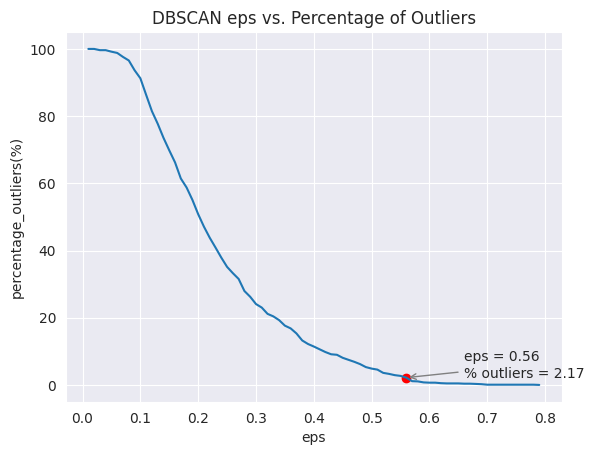

In [15]:
results, best_eps = search_eps_dbscan(insurance, plot = True, verbose = True)

## clean_outliers_using_DBscan

In [12]:
def clean_outliers_using_dbscan(
    df: pd.DataFrame, 
    eps: float, 
    distance_metric: str = 'manhattan', 
    min_samples: int = 5,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Remove outliers using DBSCAN clustering.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    eps : float
        The maximum distance between two samples for one to be considered
        as in the neighborhood of the other.
    distance_metric : str, optional
        Distance metric to use for DBSCAN. Default is 'manhattan'.
    min_samples : int, optional
        Minimum number of points to form a dense region. Default is 5.
    verbose : bool, optional
        If True, prints detailed logging.

    Returns
    -------
    pd.DataFrame
        DataFrame with outliers removed.
    """
    df_clean = df.copy()

    # Drop empty columns and rows with NaNs
    initial_shape = df_clean.shape
    df_temp = df_clean.dropna(axis='columns', how='all').dropna(axis='rows', how='any')
    cleaned_shape = df_temp.shape

    if verbose:
        print(f'Removed {initial_shape[0] - cleaned_shape[0]} rows and '
              f'{initial_shape[1] - cleaned_shape[1]} columns with missing values.')

    # Save original indices
    original_indices = df_temp.index

    # Encode categoricals and scale
    df_temp = pd.get_dummies(df_temp, drop_first=True)
    scaled = MinMaxScaler().fit_transform(df_temp)

    # DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=distance_metric, n_jobs=-1)
    labels = db.fit_predict(scaled)

    # Identify outliers
    outlier_indices = original_indices[labels == -1]
    if verbose:
        print(f'Removing {len(outlier_indices)} outliers '
              f'({round(len(outlier_indices) / len(df_clean) * 100, 2)}%)')

    # Drop outliers
    return df_clean.drop(index=outlier_indices)


### Example

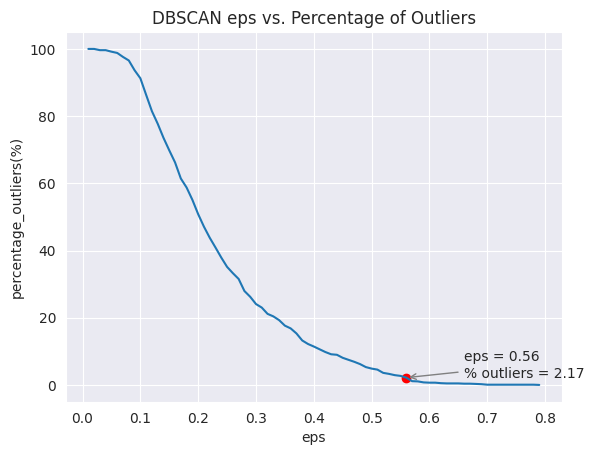

Removed 0 rows and 0 columns with missing values.
Removing 29 outliers (2.17%)


In [16]:
_, best_eps = search_eps_dbscan(insurance, plot = True, verbose = True)
insurance_cleaned = clean_outliers_using_dbscan(insurance, best_eps, verbose = True)